# Notebook to analyze the data from AGNs catalogs

First, we import the packages to be used

To get the first line working, you need  
to run the following lines:

```bash
 conda install nodejs
 pip install ipympl
 pip install --upgrade jupyterlab
 jupyter labextension install @jupyter-widgets/jupyterlab-manager
 jupyter labextension install jupyter-matplotlib
 jupyter nbextension enable --py widgetsnbextension
 ```

In [16]:
%matplotlib inline
# Static plots
#%matplotlib ipympl
# Interactive plots
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patheffects as mpe
# from matplotlib.ticker import FormatStrFormatter
# from matplotlib.patches import Polygon
from astropy.io import fits
from astropy.table import Table
from astropy.table import Column
from astropy.table import MaskedColumn
from astropy.table import hstack
from astropy.table import vstack
from astropy.table import join
# from astropy.wcs import WCS
from astropy import units as u
# from astropy.visualization import hist
from astropy.coordinates import SkyCoord
from astropy.cosmology import FlatLambdaCDM
# from astroquery.simbad import Simbad
# from astroquery.ned import Ned
import getpass
import progressbar
import pandas as pd
import re

Define the spectral index $\alpha$ from different sources  
to be used in the luminosity calculations (K-correction)

In [11]:
alpha_first = 0.5  # From FIRST data (Bornancini+2010)
alpha_RG    = 1.0  # For radio galaxies (Verkhodanov & Khabibullina, 2010)
alpha_alex  = 0.8  # Star-forming galaxies (Alexander+2003)
alpha_smol  = 0.7  # Mean value from VLA-COSMOS 3GHz sample (Smolčić et al. 2017)
alpha_butl  = 0.75  # From Butler et al., 2018

Choose one of the spectral indexes

In [12]:
alpha_used  = alpha_butl

---

## Reading data

In [2]:
machine  = getpass.getuser()
# cat_path = '/home/' + machine + '/Documentos/Data/'
cat_path = ''  # relative path to the same directory

In [3]:
large_catalog_df = pd.read_hdf(cat_path + 'large_cat_simbad_inayoshi_ned.h5', 'df')  # Remember columns with 'Flux Density...' are in Jy (not mJy as the others)

In [ ]:
large_catalog_tab = Table.from_pandas(large_catalog_df)

To access data:

In [9]:
redshift    = large_catalog_df['Z_OWN']
redshift_e  = large_catalog_df['Z_OWN_ERR']
L_20cm      = large_catalog_df['L_20CM']
L_20cm_e    = large_catalog_df['L_20CM_ERR']
L_20cm_up_l = large_catalog_df['L_20CM_UP_LIM']

In [17]:
cosmo          = FlatLambdaCDM(H0=70, Om0=0.3)
z_range        = np.arange(0, 10.2, 0.25)  # array to be used in other instances
lum_dist_range = cosmo.luminosity_distance(z_range).to(u.m).value  # in m

In [18]:
lum_FIRST   = 4 * np.pi * lum_dist_range**2 * 1e-3  * 1e-26 * (1 + z_range)**(alpha_used - 1)
lum_50uJy   = 4 * np.pi * lum_dist_range**2 * 50e-6 * 1e-26 * (1 + z_range)**(alpha_used - 1)
lum_20uJy   = 4 * np.pi * lum_dist_range**2 * 20e-6 * 1e-26 * (1 + z_range)**(alpha_used - 1)
lum_10uJy   = 4 * np.pi * lum_dist_range**2 * 10e-6 * 1e-26 * (1 + z_range)**(alpha_used - 1)
lum_1uJy    = 4 * np.pi * lum_dist_range**2 * 1e-6  * 1e-26 * (1 + z_range)**(alpha_used - 1)

In [7]:
cmap        = cm.get_cmap('inferno')
dark_color  = cmap(0.4)  # RGBA color code
light_color = cmap(0.6)  # RGBA color code
colors      = [cmap(0.15), cmap(0.30), cmap(0.45), cmap(0.60), cmap(0.75), cmap(0.90)]
colors_8    = [cmap(0.12), cmap(0.24), cmap(0.35), cmap(0.48), cmap(0.6), cmap(0.72), cmap(0.84), cmap(0.96)]

In [8]:
pe1 = [mpe.Stroke(linewidth=3, foreground='black'),
       mpe.Stroke(foreground='white', alpha=1),
       mpe.Normal()]

alp_str     = r'$\alpha$'

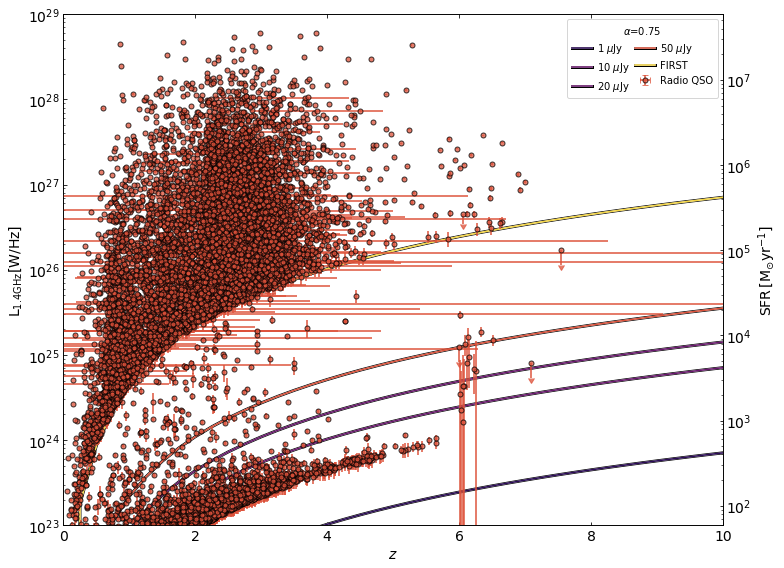

In [19]:
fig = plt.figure(figsize=(11,8))
ax1 = fig.add_subplot(111)

ax1.errorbar(redshift, L_20cm, xerr=redshift_e, yerr=L_20cm_e, marker='.', ls='', color=colors[3], markersize=10, zorder=7, alpha=0.75, uplims=L_20cm_up_l, elinewidth=2, mec='k', label='Radio QSO')

#ax1.errorbar(high_z_zs[filter_250GHz], lum_250_new_alpha_rescale[filter_250GHz], yerr=lum_250_new_alpha_rescale_e[filter_250GHz], marker='P', ls='', color=colors[4], markersize=10, zorder=7, alpha=0.65, uplims=high_z_up_lim[filter_250GHz], elinewidth=2, mec='k', label='mm QSO')

ax1.plot(z_range, lum_1uJy, label='1 $\mu$Jy', color=colors[0], path_effects=pe1)
ax1.plot(z_range, lum_10uJy, label='10 $\mu$Jy', color=colors[1], path_effects=pe1)
ax1.plot(z_range, lum_20uJy, label='20 $\mu$Jy', color=colors[1], path_effects=pe1)
ax1.plot(z_range, lum_50uJy, label='50 $\mu$Jy', color=colors[3], path_effects=pe1)
ax1.plot(z_range, lum_FIRST, label='FIRST', color=colors[5], path_effects=pe1)
#ax1.plot(z_range, SFR_3000, label='3000M_sun/yr', color=colors[2], path_effects=pe1)
#ax1.fill_between(z_range, SFR_3000 - SFR_3000_e, SFR_3000 + SFR_3000_e, color=colors[2], fc=colors[2], alpha=0.3, zorder=6)
#gradient_fill(z_range, max_pow_sfr_fix + 3 * max_pow_sfr_fix_e, fill_color=colors[4], color=colors[4], label='SFR - fixed M', zorder=5, ax=ax1)
#ax1.plot(z_range, max_pow_sfr_fix, '-', color=colors[4], alpha=0.45)
#gradient_fill(z_range, max_pow_sfr + 3 * max_pow_sfr_e, fill_color=colors[3], color=colors[3], label='SFR - evolv. M', zorder=5, ax=ax1)
#ax1.plot(z_range, max_pow_sfr, '-', color=colors[3], alpha=0.45)
ax1.set_xlabel('$z$', size=14)
ax1.set_ylabel('$\mathrm{L}_{1.4 \mathrm{GHz}} [\mathrm{W/Hz}]$', size=14)
ax1.set_yscale('log')
ax1.set_ylim((1e23, 1e29))
ax1.set_xlim(left=-0.001, right=10)
#ax1.set_xlim(left=5.5, right=8)
ax1.legend(loc=1, title=f'{alp_str}={alpha_used}', ncol=2, labelspacing=0.5, borderpad=0.5, columnspacing=0.5, handletextpad=0.5)


ax2 = ax1.twinx()
ax2.set_ylabel('$\mathrm{SFR}\, [\mathrm{M}_{\odot} \mathrm{yr}^{-1}]$', size=14)
ax2.set_ylim((1e23 * 5.9e-22, 1e29 * 5.9e-22))
ax2.set_yscale('log')
ax2.figure.canvas.draw()

#plt.setp(ax2.get_yticklabels(), visible=False)
ax1.tick_params(which='both',top=True, right=False, direction='in')
ax2.tick_params(which='both',top=True, right=True, direction='in', labelright=True)

ax1.tick_params(axis='both', which='major', labelsize=14)
ax2.tick_params(axis='both', which='major', labelsize=14)
fig.tight_layout(w_pad=0.01)